In [20]:
import root_numpy as rnp
import numpy as np
import matplotlib.pyplot as plt
from pylab import meshgrid
import matplotlib.colors as colors
import matplotlib as mpl
from uncertainties import ufloat
%matplotlib inline
import pandas as pd
from scipy.stats import multinomial
import ROOT
from uncertainties import correlated_values
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'invalid': 'ignore', 'over': 'warn', 'under': 'ignore'}

In [21]:
radius = .125
pitchY = .275
pitchZ = np.sqrt(4*radius**2-pitchY**2/4)

center = [(0,0)]
diag = [(0,1),(1,0),(-1,0),(0,-1)]
same = [(1,-1),(-1,1)]
above = [(1,1),(-1,-1)]
coordinates  = center + diag + same + above
other_coordinates = [(-3,0),(-2,1),(-3,1),(-2,0),(-2,-1),(1,-2,),(1,-3),(0,-2),(0,-3),(-1,-2),
                     (2,-2),(-2,2),(2,-1),(-1,2),(-1,3),(0,2),(2,0),(3,-1)]

def coord2pos(coord):
    i, j = coord
    return (pitchY/2*(i-j),pitchZ*(i+j))
def pos2coord(pos):
    y,z = pos
    return (y/pitchY + z/(2*pitchZ), -y/pitchY + z/(2*pitchZ))
    
fibres = [coord2pos(c) for c in coordinates]
other_fibres = [coord2pos(c) for c in other_coordinates]

@np.vectorize
def number2class(fibreNo):
    if fibreNo == 0 or fibreNo >9:
        return "other"
    elif fibreNo == 1:
        return "center"
    elif fibreNo <=5:
        return "class_1"
    elif fibreNo <= 7:
        return "class_2"
    else:
        return "class_3"
    
def isInFibre(ys, zs, centerY, centerZ, radius=.125):
    return (ys-centerY)**2 + (zs-centerZ)**2 < radius**2
def getFibre(ys, zs, fibres):
    ids = np.zeros(len(ys))
    for (i,(fibre)) in enumerate(fibres):
        ids[isInFibre(ys,zs, *fibre)] = i+1
    return ids
    
def plot_2d_hist(data, bins_x, bins_y,ax=None, **kwargs):
    if not ax:
        ax = plt.gca()
    return ax.imshow(data.T, interpolation='none', origin='lower',extent=(bins_x[0],bins_x[-1],bins_y[0],bins_y[-1]),**kwargs)


In [22]:
nJobs = 60
datasets = []
uv_datasets = []
for jobId in range(nJobs):
    datasets.append(rnp.root2array('/fhgfs/users/mbieker/multi-fibre-sim/multi-fibre-sim-01-22-18_%i/outFile.root'%jobId,
                                     treename='DetectedPhotons'))
    uv_datasets.append(rnp.root2array('/fhgfs/users/mbieker/multi-fibre-sim/multi-fibre-sim-01-22-18_%i/outFile.root'%jobId,
                                     treename='PrimaryParticles'))
raw_data = np.concatenate(datasets)
uv_data = np.concatenate(uv_datasets)
n_total = 200000*nJobs

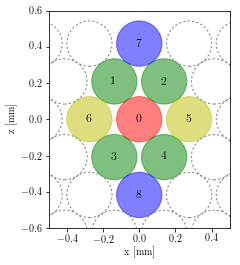

In [23]:
def getClassColor(idx):
    if idx ==0:
        return "r"
    if idx < 5:
        return "g"
    if idx < 7 :
        return "y"
    else:
        return "b"
for i, fibre in enumerate(fibres):
    plt.gca().add_patch(plt.Circle(fibre, radius,color=getClassColor(i), fill=True,alpha=.5))
    plt.text(fibre[0],fibre[1], str(i),fontdict={'size':12,'va':'center','ha':'center'})
for i, fibre in enumerate(other_fibres):
    plt.gca().add_patch(plt.Circle(fibre, radius, fill=False, color="grey",linestyle=":" ))
    
plt.axis([-0.5, 0.5, -0.6, 0.6])
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel("x [mm]")
plt.ylabel("z [mm]")
plt.savefig('plots/fibre_map.pdf')

## Aply reflective losses to data

Probability to survive

$p_\text{survival} = (1-p_\text{loss})^{n_\text{core-clad}+n_\text{clad-clad}}$

In [24]:
single_refl_loss_prob = 5e-5
survival_prob = (1-single_refl_loss_prob)**(raw_data['reflTotalCoreClad']+raw_data['reflTotalCladClad'])
data = raw_data[survival_prob> np.random.rand(len(raw_data))]

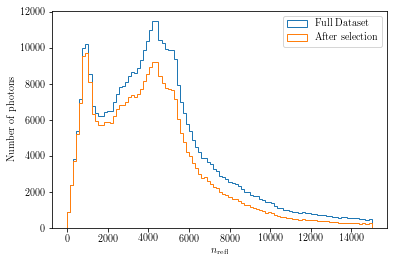

In [25]:
plt.close()

plt.hist((raw_data['reflTotalCoreClad']+raw_data['reflTotalCladClad']),bins=100,range=(0,15000),histtype='step'
         ,label='Full Dataset')
plt.hist((data['reflTotalCoreClad']+data['reflTotalCladClad']),bins=100,range=(0,15000),histtype='step'
         , label='After selection')
plt.legend()
plt.ylabel('Number of photons')
plt.xlabel('$n_\mathrm{refl}$')
plt.savefig("plots/surmann-cut.pdf")
plt.show()

## Total CT

Get total CT and calculate covariance matrix based on multinomial distribution

In [26]:
def calc_total_ct(data, relative=True):
    counts = pd.Series(number2class(getFibre(data["y"], data["z"], fibres)), dtype="category").value_counts()
    counts.drop("other", inplace=True)
    if relative:
        return counts/counts[0]
    else:
        return counts

In [27]:
#multinomial
for ex_pos in [-1245.,-250.,750]:
    ns = np.zeros(5)
    counts = calc_total_ct(data[data['gpsPosX'] == ex_pos], False)
    ns[1:] = counts
    ns[0] = n_total-counts.sum()
    cov = multinomial.cov(n_total, ns/n_total)
    vals = np.array(correlated_values(ns, cov))
    print(ex_pos)
    print (*(vals[1:]/vals[1:].sum()), sep="   ")
    

-1245.0
0.8264+/-0.0008   0.1128+/-0.0006   0.0508+/-0.0004   0.01006+/-0.00020
-250.0
0.8194+/-0.0021   0.1164+/-0.0017   0.0540+/-0.0012   0.0102+/-0.0005
750
0.8220+/-0.0017   0.1162+/-0.0014   0.0514+/-0.0010   0.0104+/-0.0005


In [28]:
#poisson
total = np.zeros(4, dtype="object")
for ex_pos in [-1245.,-250.,750]:
    ns = np.zeros(4)
    ns = calc_total_ct(data[data['gpsPosX'] == ex_pos], False)
    cov = np.diag(ns)
    vals = np.array(correlated_values(ns, cov))
    total += vals
    print(ex_pos)
    print (*(vals/vals.sum()), sep="   ")
print (*(total/total.sum()), sep="  & ")


-1245.0
0.8264+/-0.0008   0.1128+/-0.0006   0.0508+/-0.0004   0.01006+/-0.00020
-250.0
0.8194+/-0.0021   0.1164+/-0.0017   0.0540+/-0.0012   0.0102+/-0.0005
750
0.8220+/-0.0017   0.1162+/-0.0014   0.0514+/-0.0010   0.0104+/-0.0005
0.8250+/-0.0007  & 0.1137+/-0.0005  & 0.0512+/-0.0004  & 0.01012+/-0.00017


## Sample Events

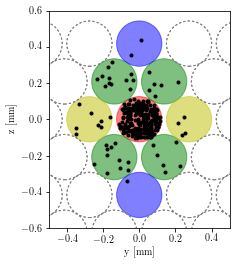

In [29]:
for i, fibre in enumerate(fibres):
    plt.gca().add_patch(plt.Circle(fibre, radius,color=getClassColor(i), fill=True,alpha=.5))
for i, fibre in enumerate(other_fibres):
    plt.gca().add_patch(plt.Circle(fibre, radius, fill=False, color="grey",linestyle=":" ))

for i, fibre in enumerate(other_fibres):
    plt.gca().add_patch(plt.Circle(fibre, radius, fill=False, color="grey",linestyle=":" ))
plt.plot(data["y"][:300], data["z"][:300], ".k")    
plt.axis([-0.5, 0.5, -0.6, 0.6])
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel("y [mm]")
plt.ylabel("z [mm]")
plt.savefig('plots/ct_example.pdf')


## Primary particles

Make map of primary UV distributions. Binning here influences all plots.

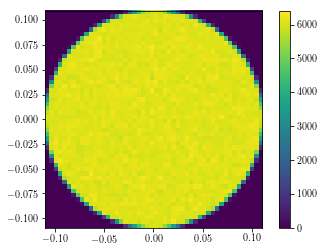

In [30]:
uv_map, bins_x, bins_y,_ = plt.hist2d(uv_data["gpsPosY"],uv_data["gpsPosZ"], bins=50)
plt.gca().set_aspect('equal', adjustable='box')
plt.colorbar()
plt.savefig("plots/uv_map.pdf")

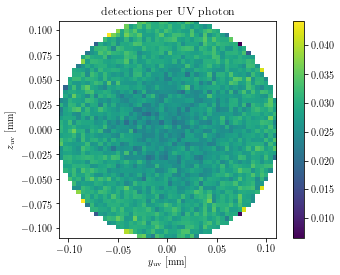

In [31]:
fig, ax= plt.subplots()
total_map,_,_ = np.histogram2d(data["gpsPosY"], data["gpsPosZ"],bins=[bins_x,bins_y])
im =   plot_2d_hist(total_map/uv_map, bins_x, bins_y, ax)
fig.colorbar(im)
ax.set_title('detections per UV photon')
ax.set_aspect('equal', adjustable='box')
ax.set_xlabel('$y_\mathrm{uv}$ [mm]')
ax.set_ylabel('$z_\mathrm{uv}$ [mm]')
fig.savefig('plots/total_relative.pdf')

In [32]:
crosstalk_maps = []
for i in range(9):
    mask = isInFibre(data['y'],data['z'], *fibres[i])
    crosstalk_maps.append(np.histogram2d(data['gpsPosY'][mask],data["gpsPosZ"][mask], bins=(bins_x,bins_y)))


/home/mbieker/miniconda3/envs/RootNotebook/lib/python3.4/site-packages/matplotlib/colors.py:1117: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  result[res_mask] = 0
/home/mbieker/miniconda3/envs/RootNotebook/lib/python3.4/site-packages/matplotlib/colors.py:1117: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  result[res_mask] = 0


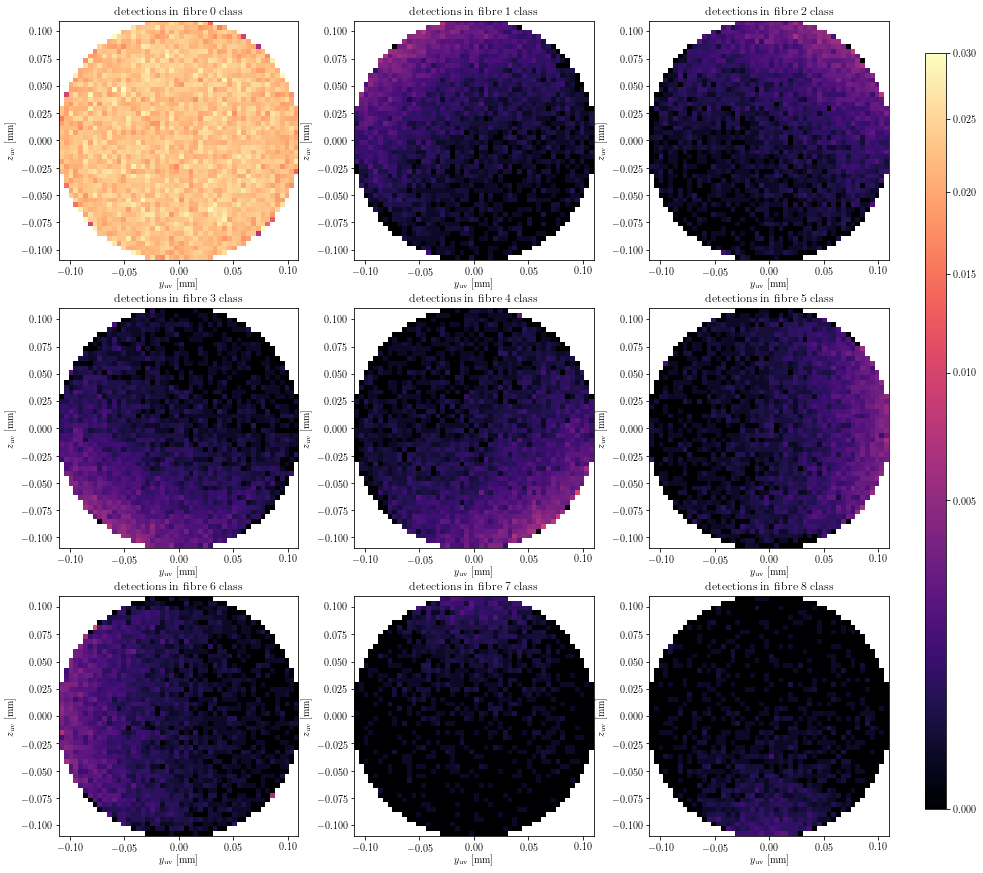

In [14]:
fig, axes = plt.subplots(3,3, figsize = (15,15)) 

for i, (ax, cmap) in enumerate(zip(axes.flatten(),crosstalk_maps)):
    ax.set_title('detections in fibre %i class' % i)
    ax.set_xlabel('$y_\mathrm{uv}$ [mm]')
    ax.set_ylabel('$z_\mathrm{uv}$ [mm]')
    map, bins_y, bins_z = cmap
    im = plot_2d_hist(map/uv_map,bins_y,bins_z,ax=ax, norm=colors.PowerNorm(gamma=0.5,vmax=0.03,vmin=0), cmap=plt.get_cmap("magma"))
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)
fig.savefig('plots/all_relative.pdf')
plt.show()

/home/mbieker/miniconda3/envs/RootNotebook/lib/python3.4/site-packages/matplotlib/colors.py:1117: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  result[res_mask] = 0
/home/mbieker/miniconda3/envs/RootNotebook/lib/python3.4/site-packages/matplotlib/colors.py:1117: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  result[res_mask] = 0


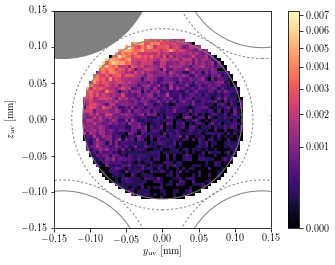

In [15]:
fig, ax = plt.subplots()
ax.set_xlim(-.15,.15)
ax.set_ylim(-.15,.15)
ax.set_xlabel('$y_\mathrm{uv}$ [mm]')
ax.set_ylabel('$z_\mathrm{uv}$ [mm]')
ax.set_aspect("equal", adjustable="box")
#fibre geometry
for i,fibre in enumerate(fibres):
    if i == 1:
        ax.add_patch(plt.Circle(fibre, radius, fill=True, color="grey" ))
    else:
        ax.add_patch(plt.Circle(fibre, radius, fill=False, color="grey",linestyle=":" ))
    ax.add_patch(plt.Circle(fibre, radius*0.88, fill=False, color="grey",linestyle="-" ))
map, bins_y, bins_z = crosstalk_maps[1]
im = plot_2d_hist(map/uv_map,bins_y,bins_z,ax=ax, norm=colors.PowerNorm(gamma=.5,vmin=0), cmap=plt.get_cmap("magma"))
fig.colorbar(im)
fig.savefig("plots/class_one_relative.pdf")

/home/mbieker/miniconda3/envs/RootNotebook/lib/python3.4/site-packages/matplotlib/colors.py:1117: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  result[res_mask] = 0
/home/mbieker/miniconda3/envs/RootNotebook/lib/python3.4/site-packages/matplotlib/colors.py:1117: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  result[res_mask] = 0


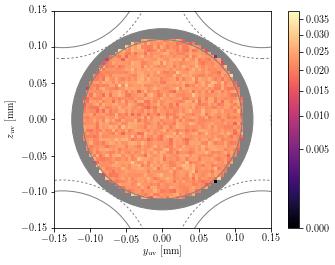

In [36]:
fig, ax = plt.subplots()
ax.set_xlim(-.15,.15)
ax.set_ylim(-.15,.15)
ax.set_xlabel('$y_\mathrm{uv}$ [mm]')
ax.set_ylabel('$z_\mathrm{uv}$ [mm]')
ax.set_aspect("equal", adjustable="box")
#fibre geometry
for i,fibre in enumerate(fibres):
    if i == 0:
        ax.add_patch(plt.Circle(fibre, radius, fill=True, color="grey", zorder=0))
    else:
        ax.add_patch(plt.Circle(fibre, radius, fill=False, color="grey",linestyle=":" ))
    ax.add_patch(plt.Circle(fibre, radius*0.88, fill=False, color="grey",linestyle="-" ))
map, bins_y, bins_z = crosstalk_maps[0]
im = plot_2d_hist(map/uv_map,bins_y,bins_z,ax=ax, norm=colors.PowerNorm(gamma=.5,vmin=0), cmap=plt.get_cmap("magma"))
fig.colorbar(im)
fig.savefig("plots/class_zero_relative.pdf")